In [20]:
import cv2
import itertools
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
imlist = {}
path = "images/"
image_count = 0
for each in glob(path + "*"):
    word = each.split("/")[-1]
    imlist[word] = []
    for imagefile in glob(path+word+"/*"):
        im = cv2.imread(imagefile, 0)
        imlist[word].append(im)
        image_count +=1

In [3]:
descriptor_list = []
labels = []
name_dict = {}
label_count = 0 
sift = cv2.xfeatures2d.SIFT_create()
for word in imlist:
    name_dict[label_count] = word
    for im in imlist[word]:
        kp, des = sift.detectAndCompute(im,None);
        descriptor_list.append(des)
        labels.append(label_count)
    label_count += 1

In [4]:
split = 0.5
train_descriptors = []
test_descriptors = []
train_labels = []
test_labels = []
train_indices = np.random.choice(image_count, int(split * image_count), replace = False)
for i in train_indices :
    train_descriptors.append(descriptor_list[i])
    train_labels.append(labels[i])
    
test_indices = [x for x in range(image_count) if x not in train_indices]
for i in test_indices :
    test_descriptors.append(descriptor_list[i])
    test_labels.append(labels[i])

In [5]:
formatted_descriptors = np.array(train_descriptors[0])
for i in train_descriptors[1:]:
    formatted_descriptors = np.vstack((formatted_descriptors, i))

In [97]:
n_clusters = 24
train_count = len(train_indices)
test_count = len(test_indices)

In [98]:
print(train_count, test_count)

680 681


In [99]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans_result = kmeans.fit_predict(formatted_descriptors)

In [100]:
histogram = np.array([np.zeros(n_clusters) for i in range(train_count)])
old_count = 0
for i in range(train_count):
    l = len(train_descriptors[i])
    for j in range(l):
        idx = kmeans_result[old_count+j]
        histogram[i][idx] += 1
    old_count += l

In [101]:
histogram.shape

(680, 24)

In [102]:
def plot_histogram(histogram, n_clusters):
    x_scalar = np.arange(n_clusters)
    y_scalar = np.array([abs(np.sum(histogram[:,h], dtype=np.int32)) for h in range(n_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

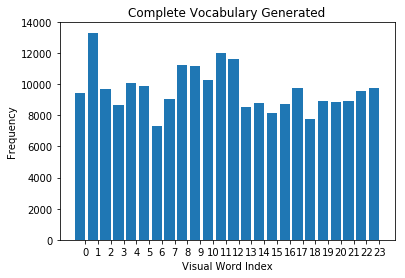

In [103]:
plot_histogram(histogram, n_clusters)

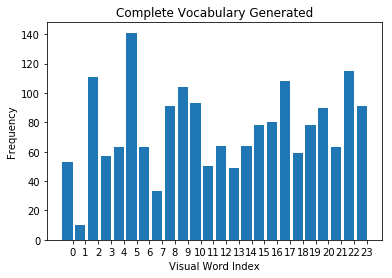

In [104]:
scale = StandardScaler().fit(histogram)
histogram_n = scale.transform(histogram)
plot_histogram(histogram_n, n_clusters)

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

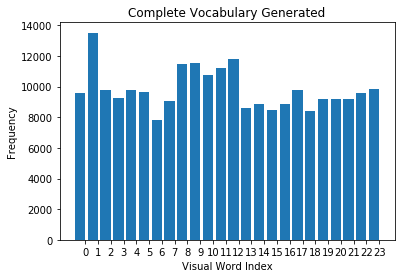

In [106]:
test_histogram = np.array([np.zeros(n_clusters) for i in range(test_count)])
for i in range(test_count) :
    predictions = kmeans.predict(test_descriptors[i])
    for j in range(len(predictions)) :
        test_histogram[i][predictions[j]] += 1
plot_histogram(test_histogram, n_clusters)

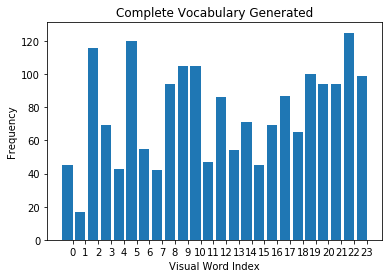

In [107]:
scale = StandardScaler().fit(test_histogram)
test_histogram_n = scale.transform(test_histogram)
plot_histogram(test_histogram_n, n_clusters)

In [108]:
class_names = [name_dict[x] for x in name_dict]

Accuracy:  0.794419970631
Normalized confusion matrix
[[ 0.66063348  0.27149321  0.0678733 ]
 [ 0.09022556  0.87969925  0.03007519]
 [ 0.14754098  0.13114754  0.72131148]]


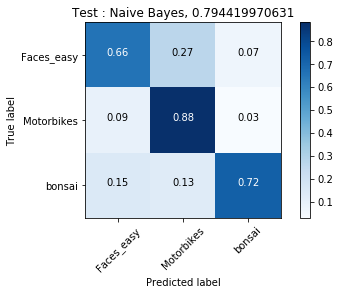

In [109]:
# Test Data

clf = GaussianNB()
clf.fit(histogram_n, train_labels)
predictions_score = clf.score(test_histogram_n, test_labels)
print("Accuracy: ", predictions_score)
predictions = clf.predict(test_histogram_n)
cnf_matrix = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Test : Naive Bayes, ' + str(predictions_score))

Accuracy:  0.8
Normalized confusion matrix
[[ 0.69158879  0.22429907  0.08411215]
 [ 0.0802005   0.87969925  0.04010025]
 [ 0.19402985  0.13432836  0.67164179]]


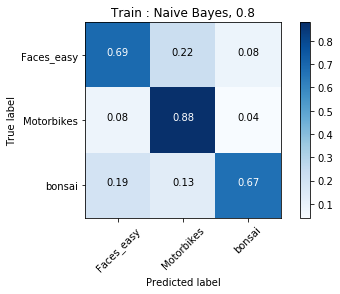

In [110]:
# Train Data

clf = GaussianNB()
clf.fit(histogram_n, train_labels)
predictions_score = clf.score(histogram_n, train_labels)
print("Accuracy: ", predictions_score)
predictions = clf.predict(histogram_n)
cnf_matrix = confusion_matrix(train_labels, predictions)
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Train : Naive Bayes, ' + str(predictions_score))

Accuracy:  0.863436123348
Normalized confusion matrix
[[ 0.8280543   0.11312217  0.05882353]
 [ 0.06265664  0.90977444  0.02756892]
 [ 0.1147541   0.19672131  0.68852459]]


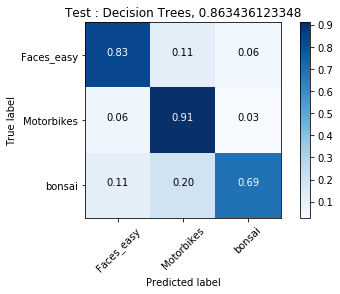

In [111]:
# Test Data

clf = tree.DecisionTreeClassifier()
clf.fit(histogram_n, train_labels)
predictions_score = clf.score(test_histogram_n, test_labels)
print("Accuracy: ", predictions_score)
predictions = clf.predict(test_histogram_n)
cnf_matrix = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Test : Decision Trees, ' + str(predictions_score))

Accuracy:  1.0
Normalized confusion matrix
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


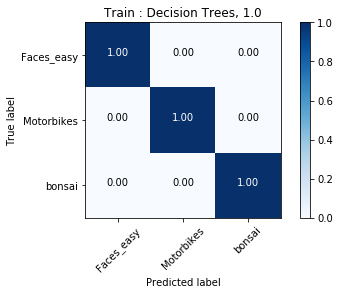

In [112]:
# Train Data

clf = tree.DecisionTreeClassifier()
clf.fit(histogram_n, train_labels)
predictions_score = clf.score(histogram_n, train_labels)
print("Accuracy: ", predictions_score)
predictions = clf.predict(histogram_n)
cnf_matrix = confusion_matrix(train_labels, predictions)
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Train : Decision Trees, ' + str(predictions_score))

Accuracy:  0.932452276065
Normalized confusion matrix
[[ 0.87782805  0.07239819  0.04977376]
 [ 0.01253133  0.97744361  0.01002506]
 [ 0.03278689  0.13114754  0.83606557]]


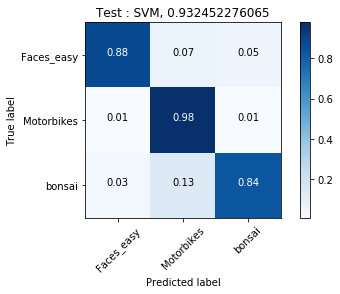

In [113]:
# Test Data

clf = svm.SVC()
clf.fit(histogram_n, train_labels)
predictions_score = clf.score(test_histogram_n, test_labels)
print("Accuracy: ", predictions_score)
predictions = clf.predict(test_histogram_n)
cnf_matrix = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Test : SVM, ' + str(predictions_score))

Accuracy:  0.970588235294
Normalized confusion matrix
[[ 0.95327103  0.04205607  0.0046729 ]
 [ 0.00250627  0.9924812   0.00501253]
 [ 0.01492537  0.08955224  0.89552239]]


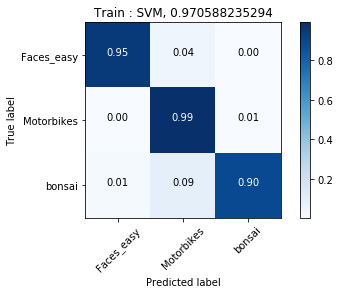

In [114]:
# Train Data

clf = svm.SVC()
clf.fit(histogram_n, train_labels)
predictions_score = clf.score(histogram_n, train_labels)
print("Accuracy: ", predictions_score)
predictions = clf.predict(histogram_n)
cnf_matrix = confusion_matrix(train_labels, predictions)
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Train : SVM, ' + str(predictions_score))